# Libraries


In [ ]:
# !pip install -r ~/code/benitomartin/FoodScore/requirements.txt
# !pip install tensorflow-addons

In [24]:
import os
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers 
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications import VGG16,ResNet152
from tensorflow.keras.utils import load_img, img_to_array, to_categorical, image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.resnet import preprocess_input
from datetime import datetime

import pickle

# Data import

## Split Test and Validation Set

In [14]:
data_dir = f"../raw_data/UECFOOD100/"

In [15]:
img_height = 300
img_width = 300

In [16]:
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128,
  shuffle=True,
  interpolation='bilinear',
  label_mode='categorical',
  )

val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128,
  shuffle=True,
  interpolation='bilinear',
  label_mode='categorical',
)


val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

Found 14361 files belonging to 100 classes.
Using 11489 files for training.
Found 14361 files belonging to 100 classes.
Using 2872 files for validation.


# Create Augmentation Class

In [17]:
class RandomBlurHue(tf.keras.layers.Layer):

    def __init__(self, kernel_size=5, sigma_max=3.0, hue_max_delta=0.1):
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma_max = sigma_max
        self.hue_max_delta = hue_max_delta

    def get_config(self):
        config = super().get_config()
        config.update({
            "kernel_size": self.kernel_size,
            "sigma_max": self.sigma_max,
            "hue_max_delta": self.hue_max_delta,
        })
        return config

    def call(self, inputs, training):
        if not training:
            return inputs

        outputs = tf.image.random_hue(inputs, self.hue_max_delta)
        sigma = np.random.uniform(0.0, self.sigma_max)
        outputs = tfa.image.gaussian_filter2d(
            outputs,
            filter_shape=(self.kernel_size, self.kernel_size),
            sigma=sigma,
            name="Gaussian-blur",
            padding="REFLECT",
        )

        return outputs

# Create model

In [34]:
def create_model():
    inputs = layers.Input(shape=(300, 300, 3))
    
    # Augmentation
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomBrightness(0.3)(x)
    x = layers.RandomContrast(0.3)(x)
    x = layers.RandomZoom((-0.3, 0))(x)
    x = RandomBlurHue(kernel_size=5, sigma_max=2.0)(x)
    
    # Scaling and Normalization
    x = preprocess_input(x)
    
    # base model
    resnet = ResNet152(include_top=False, weights='imagenet')

    x = resnet(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation="softmax", name="class_label", kernel_regularizer=l2(0.01))(x)

    # Freeze ResNet weights
    resnet.trainable = False

    return Model(inputs=inputs, outputs=[x])

In [35]:
model = create_model()

# after 10 epoch (90 batch/epoch) LR is at 10^-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=90,
    decay_rate=0.8)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=lr_schedule),
    metrics="categorical_accuracy",
)

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_brightness_3 (Random  (None, 224, 224, 3)      0         
 Brightness)                                                     
                                                                 
 random_contrast_3 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                                         
                                                           

# Augmentation test

In [20]:
import itertools

x,y = next(train_ds.__iter__())

img = x[0,:,:,:]

2023-03-27 14:41:56.778844: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


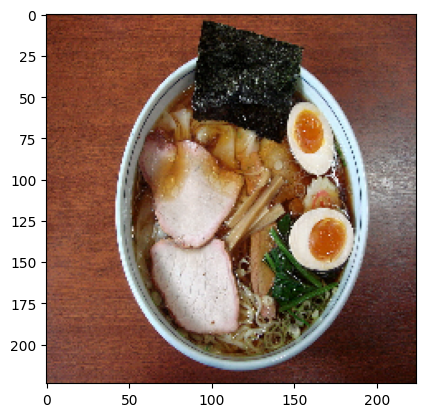

In [21]:
plt.imshow(img.numpy().astype(int))

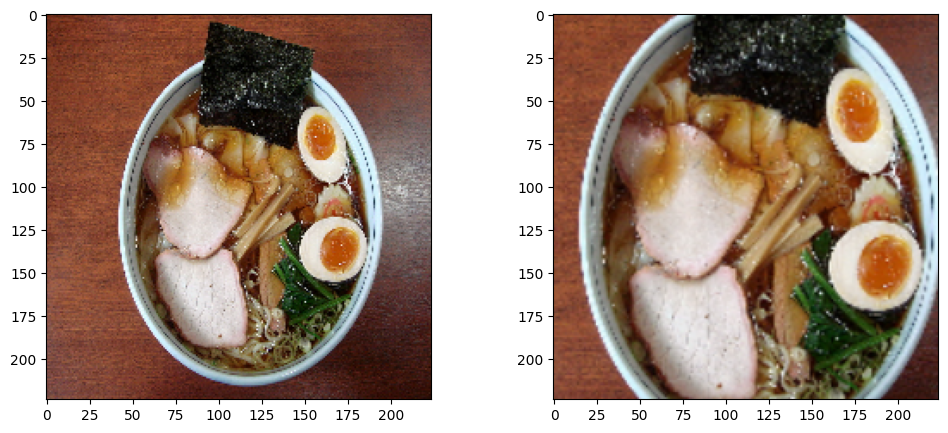

In [27]:
# test augmentation
training = True
x = img
# x = layers.RandomFlip("horizontal_and_vertical")(img, training=training)
# x = layers.RandomRotation(0.2)(x, training=training)
# x = layers.RandomBrightness(0.4)(x, training=training)
# x = layers.RandomContrast(0.4)(x, training=training)
x = layers.RandomZoom((-0.3, 0))(x, training=training)
#x = Augmentation(kernel_size=5, sigma_max=2.0)(x, training=training)

fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].imshow(img.numpy().astype(int))
axs[1].imshow(x.numpy().astype(int));

# Train the model and save it

In [36]:
working_dir = "..raw_data/experiments"
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
exp_dir = os.path.join(working_dir, f"exp-{timestamp}")
logdir = os.path.join(exp_dir, "logs")
checkpoint_file = os.path.join(exp_dir, "ckpt", "weights-{epoch:02d}-{val_categorical_accuracy:.3f}.h5")

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 0,
    restore_best_weights = True
)

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_file,
    verbose=0,
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

fit_history = model.fit(
    train_ds,
    validation_data=(val_ds),
    batch_size=128,
    epochs=1,
    verbose=1,
    callbacks = [early_stopping, model_checkpoint, tensorboard_callback],
)

# save model
model.save(os.path.join(exp_dir, 'model'))

90/90 [==============================] - 2227s 25s/step - loss: 4.9616 - categorical_accuracy: 0.0457 - val_loss: 4.5916 - val_categorical_accuracy: 0.0526


INFO:tensorflow:Assets written to: ..raw_data/experiments/exp-2023-03-27-16-15/model/assets


INFO:tensorflow:Assets written to: ..raw_data/experiments/exp-2023-03-27-16-15/model/assets


# Evaluate the model

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [ ]:
model.evaluate(test_ds)